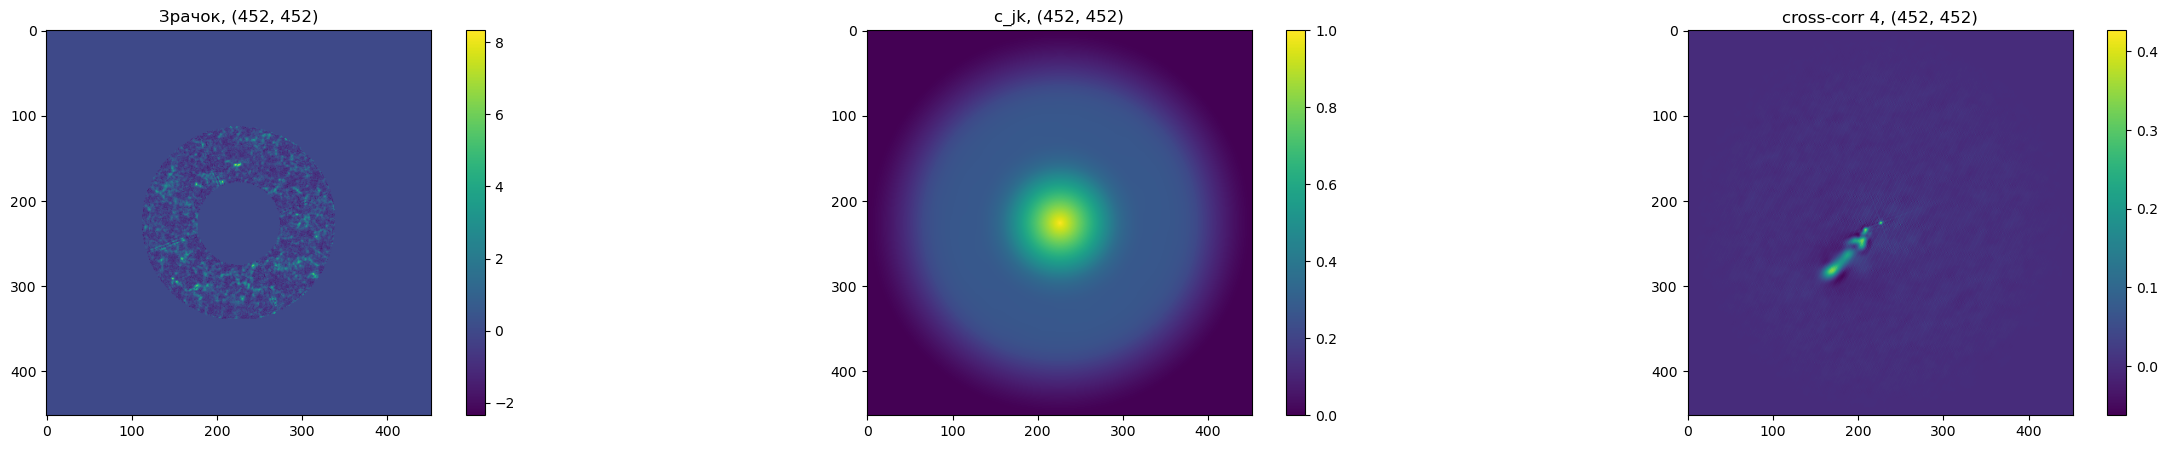

In [212]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx
    if idx == 0:
        return 0, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, z):
    global cjk, t, a1, gammas, data, delta
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    res = shift(res, (-Ypix, Xpix), order=2)  
    res = res * cjk

    k = data[data.shape[0]//2+round(Ypix), data.shape[1]//2-round(Xpix)] / res[res.shape[0]//2, res.shape[1]//2]
    
    res = res * k
    return res, k

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'C:/astro/domecam'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

pupil = np.loadtxt(f'{data_dir}/frame.gz')
data = np.loadtxt(f'{data_dir}/data_corr4.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
gammas = np.load(f'{data_dir}/gammas.npy')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]//2) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(data), ax=ax3)
ax3.grid(False)
ax3.set_title(f'cross-corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    comps=np.zeros(dirty.shape)
    res=np.array(dirty) 
    window=np.ones(dirty.shape, bool)
    
    tmp = 0
    Cn2 = []
    z = []
    vx = []
    vy = []

    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res[window]), res.shape) # fabs? # нахождение максимального значения
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
     
        if int(Vx) == 0 and int(Vy) == 0:
            myParams = [(Vx, Vy, 2000)]
        else:
            myParams = [(Vx, Vy, 15000+5000*np.sin(np.random.uniform(-np.pi, np.pi)))]
            
        psf, speckle_x, speckle_y, Cn2v, zv, vxv, vyv = multi_speckle_fit(params=myParams, ydata=res, window=window)
        Cn2.append(Cn2v*gain)
        z.append(zv)
        vx.append(vxv)
        vy.append(vyv)
        
        res -= psf*mval
#         res -= psf*gain
    
        tmp+=1
        if np.max(np.fabs(res)) < thresh: 
            print('Thresh reached!')
            break
    print('Total interations:', tmp)    
    return comps, res, Cn2, z, vx, vy


def multi_speckle_fit(params=None, ydata=None, window=None):
    global xdata, t, delta
    def speckle_fit(xcoord, ycoord, z_dist, ydata): # аппроксимация одного слоя
        def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
            x, y = M
            arr = np.zeros(x.shape)
            for i in range(len(args)//3):
                if window is not None:
                    arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0])[Ypix1-window:Ypix1+window, 
                                                                      Xpix1-window:Xpix1+window].ravel()
                else:
                    arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0]).ravel()
            return arr
        
        params = [(xcoord, ycoord, z_dist)] 
        p0 = [p for prms in params for p in prms]
        
        st=time.perf_counter()
        
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        t = sec_per_frame * latency
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        if window is not None:
            ydata = ydata[Ypix1-window:Ypix1+window, Xpix1-window:Xpix1+window]

        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)

        fit = np.zeros(X.shape) # результирующее изображение
        xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
        ydata = ydata.ravel()
        
        popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[[xcoord-3, ycoord-3, 2000],
                                                             [xcoord+3, ycoord+3, 40000]]) 
        print(f'Fitted parametrs: {popt[0]:.2f} {popt[1]:.2f} {popt[2]}')
        k_coeff=[]
        for i in range(len(popt)//3):
            if window is not None:
                fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])[Ypix1-window:Ypix1+window, 
                                                                  Xpix1-window:Xpix1+window]
            else:
                fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])
                
            k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

        print(f'Time: {time.perf_counter()-st:.4f}')
    
        Xpix = int(popt[0]*t/delta)
        Ypix = int(popt[1]*t/delta)
    
        return fit, Xpix, Ypix, k_coeff, popt[2], popt[0], popt[1]
    
    myParams = [p for prms in params for p in prms]
    res = np.zeros(data.shape)
    cr = data.shape[0]//2 # центр изображения
    Xc = []
    Yc = []
    t = sec_per_frame * latency

    for i in range(len(myParams)//3):
        print(f'Speckle fitting:', *myParams[i*3:i*3+3])
        fit, xcoord, ycoord, Cn2_fitted, zv, Vx, Vy = speckle_fit(*myParams[i*3:i*3+3], ydata)
        if window is not None:
            res[(res.shape[0]//2 - ycoord) - fit.shape[0]//2:(res.shape[0]//2 - ycoord) + fit.shape[0]//2, 
                (res.shape[1]//2 + xcoord) - fit.shape[1]//2:(res.shape[1]//2 + xcoord) + fit.shape[1]//2] += fit
        
        else:
            res +=fit
            
        Xc.append(xcoord)
        Yc.append(ycoord)

        print(f'-Cn2: {Cn2_fitted[0]*1e-13}')
        print(f'-max fitted value: {np.max(fit):.2f}')
        print(f'-max initial value: {np.max(data[cr-ycoord-4:cr-ycoord+4, cr+xcoord-4:cr+xcoord+4]):.2f}')
        print('')
    
    return res, Xc, Yc, Cn2_fitted[0]*1e-13, zv, Vx, Vy

def one_speckle_fit(params=None): 
    global data
    def _g(M, *args): # обходной способ, именно эту функцию будем аппроксимировать
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//3):
            arr += (gamma_poly_se(x, y, *args[i*3:i*3+3])[0]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) # результирующее изображение
    xdata = np.vstack((X.ravel(), Y.ravel())) # значения аргумента
    ydata = data.ravel()
    
    lb = [-np.inf, -np.inf, 2000]
    lb = np.tile(lb, len(p0)//3)
    ub = [np.inf, np.inf, 40000]
    ub = np.tile(ub, len(p0)//3)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])
    k_coeff=[]
    for i in range(len(popt)//3):
        fit += (gamma_poly_se(X, Y, *popt[i*3:i*3+3])[0])
        k_coeff.append(gamma_poly_se(X, Y, *popt[i*3:i*3+3])[1])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//3):
        print(*popt[i*3:i*3+3])

    k_coeff = np.array(k_coeff)
    return fit, popt, k_coeff*1e-13

Speckle fitting: 0.0 0.0 2000
Fitted parametrs: 0.08 0.11 2000.0000000000555
Time: 0.3080
-Cn2: 3.648698675913903e-12
-max fitted value: 0.43
-max initial value: 0.43

Speckle fitting: -15.763274336283187 -15.486725663716813 19785.54762593758
Fitted parametrs: -15.86 -15.58 4800.015005973915
Time: 1.2518
-Cn2: 5.7730993777390836e-11
-max fitted value: 4.02
-max initial value: 0.34

Speckle fitting: -14.657079646017698 -14.657079646017698 15435.44144002357
Fitted parametrs: -14.24 -13.93 15437.922441190858
Time: 0.7067
-Cn2: -2.891121769697692e-12
-max fitted value: 0.03
-max initial value: 0.31

Speckle fitting: -14.657079646017698 -14.657079646017698 12787.042916934428
Fitted parametrs: -14.38 -14.10 12523.25550457102
Time: 1.1386
-Cn2: 2.310824294768244e-12
-max fitted value: 0.36
-max initial value: 0.32

Speckle fitting: -14.657079646017698 -14.657079646017698 17763.31151455576
Fitted parametrs: -14.31 -13.97 17763.15760003109
Time: 0.5851
-Cn2: -2.6044006861996564e-12
-max fitted 

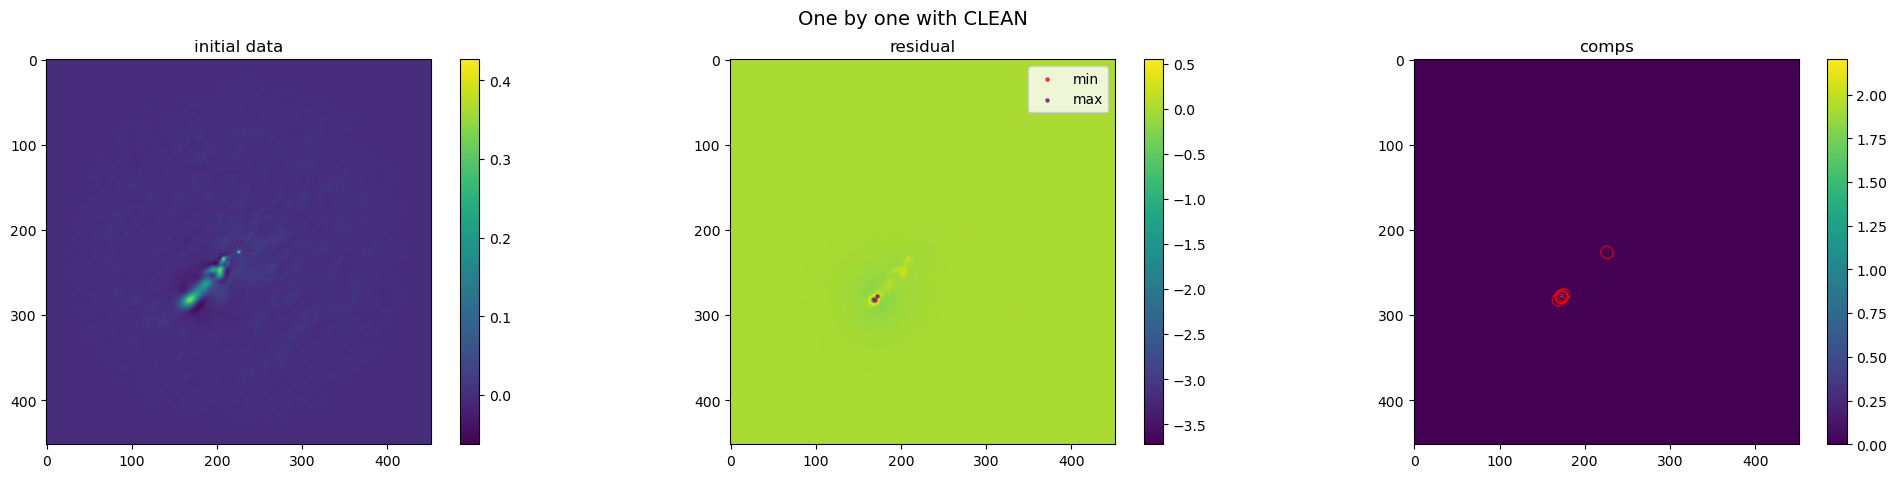

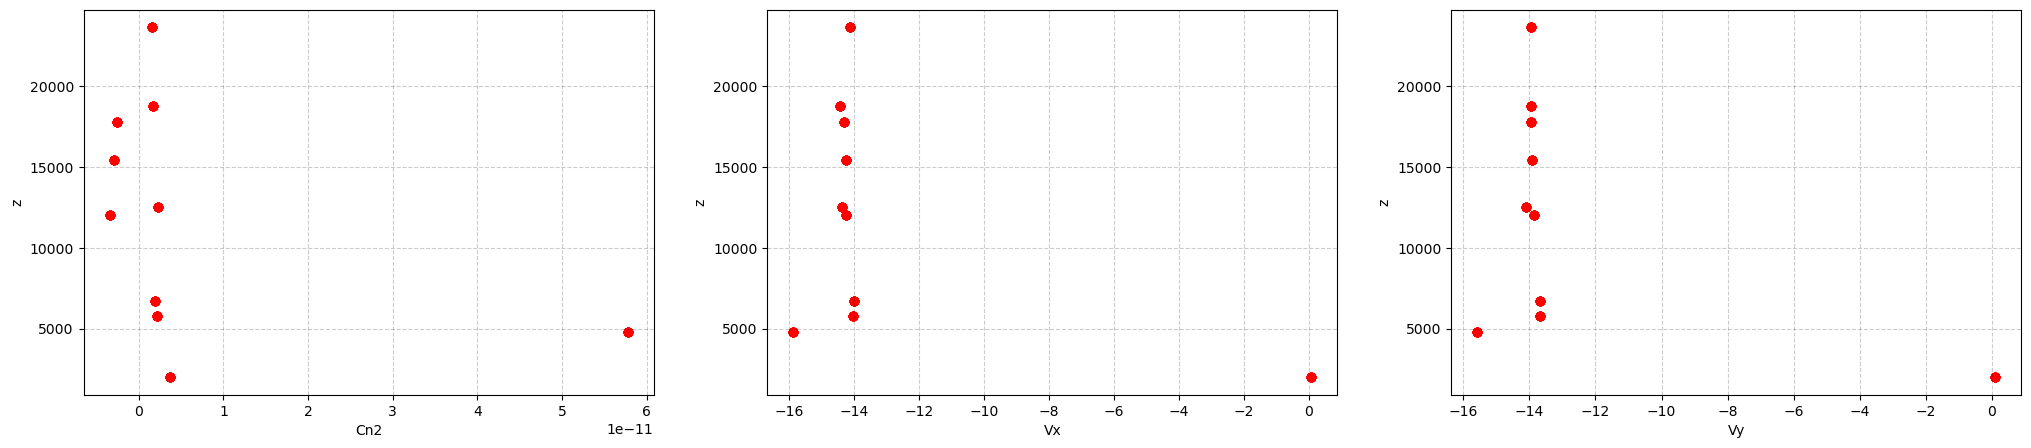

In [8]:
comps, residual, Cn2, z, vx, vy = CLEAN(data, gain=1, thresh=0.1, niter=10, window=None)

r0 = pow(0.423*pow(k, 2)*(np.sum(Cn2)), -3/5)
print(f'sum Cn2: {np.sum(Cn2)}')
print(f'r0, sm: {100*r0:.2f}')
print(f'seeing, arcsec: {0.98 * 206265 * lambda_/r0:.2f}')


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
fig.colorbar(ax.imshow(data), ax=ax)
fig.colorbar(ax2.imshow(residual), ax=ax2)
fig.colorbar(ax3.imshow(comps), ax=ax3)
a_tmp = np.where(comps!=0)
for i in range(len(a_tmp[0])):
    ax3.scatter(a_tmp[1][i], a_tmp[0][i], alpha=0.7, s=80, facecolors='none', edgecolors='r')
ax.set_title('initial data')
ax2.set_title('residual')
ax3.set_title('comps')
ax2.scatter(np.unravel_index(np.argmin(residual), residual.shape)[1], 
            np.unravel_index(np.argmin(residual), residual.shape)[0], color='red', alpha=0.7, s=5, label='min')
ax2.scatter(np.unravel_index(np.argmax(residual), residual.shape)[1],
            np.unravel_index(np.argmax(residual), residual.shape)[0], color='purple', alpha=0.7, s=5, label='max')
ax2.legend()

print('min value fit:', np.min(residual), 'coords:', np.unravel_index(np.argmin(residual), residual.shape))
print('max value fit:', np.max(residual), 'coords:', np.unravel_index(np.argmax(residual), residual.shape))
print('centr value:', residual[226, 226])

z = np.round(z, 2)
profile1 = np.stack((z, Cn2))
profile1 = profile1[:, profile1[0].argsort()]
profile1[0, :] = np.round(profile1[0, :], 2)

allCn2=[]
tmp=0
for i in range(len(profile1[0])):
    if profile1[0][i] == 2000:
        tmp+=1
        allCn2.append(profile1[1][i])

print(f'dome turb counted {tmp} times: {np.sum(allCn2)}')

profile2 = np.stack((z, vx))
profile2 = profile2[:, profile2[0].argsort()]
profile2[0, :] = np.round(profile2[0, :], 2)

profile3 = np.stack((z, vy))
profile3 = profile3[:, profile3[0].argsort()]
profile3[0, :] = np.round(profile3[0, :], 2)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

for i in range(len(profile1[0])):
    ax.scatter(profile1[1], profile1[0], color='red')
    ax2.scatter(profile2[1], profile2[0], color='red')
    ax3.scatter(profile3[1], profile3[0], color='red')
    
ax.set_xlabel('Cn2')
ax.set_ylabel('z')
ax2.set_xlabel('Vx')
ax2.set_ylabel('z')
ax3.set_xlabel('Vy')
ax3.set_ylabel('z')
ax.grid(color = 'black', linestyle='--', alpha = 0.2)
ax2.grid(color = 'black', linestyle='--', alpha = 0.2)
ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
print('')

In [3]:
myparams = np.stack((vx, vy, z))
myparams2=[]
for i in range(len(myparams[0])):
    myparams2.append((myparams[0][i], myparams[1][i], myparams[2][i]))


myparams2 = np.array(myparams2)
print(myparams2, '\nlen:', myparams2.shape, '\n')
myparams2 = np.unique(np.vectorize(round)(myparams2), axis=0)
myparams2 = myparams2[np.ndarray.argsort(myparams2[:, 2])]
print(myparams2, '\nlen:', myparams2.shape)

# a1 = np.logspace(0, 2, num=9, base=10)
# plt.plot(a1)

[[ 8.66896027e-03  1.77209697e-02  2.04116000e+03]
 [-1.58420117e+01 -1.53054585e+01  3.40585000e+04]
 [-6.22092801e+00 -6.24723428e+00  3.00000000e+04]
 [-4.99134813e+00 -3.11244845e+00  2.99998400e+04]
 [-1.19799839e+01 -1.20447967e+01  3.99993600e+04]
 [-8.74560893e+00 -5.87232779e+00  1.71539900e+04]
 [-4.69375227e+00 -2.52306595e-02  1.06321300e+04]
 [-4.06616953e+00 -9.67900850e-01  3.89178600e+04]
 [-4.29246804e+00 -1.21342894e+00  3.30588500e+04]
 [-4.16096140e+00 -1.00553032e+00  3.01792000e+03]] 
len: (10, 3) 

[[    0     0  2041]
 [   -4    -1  3018]
 [   -5     0 10632]
 [   -9    -6 17154]
 [   -6    -6 30000]
 [   -5    -3 30000]
 [   -4    -1 33059]
 [  -16   -15 34058]
 [   -4    -1 38918]
 [  -12   -12 39999]] 
len: (10, 3)


Time: 259.5332
-0.23132443111213036 0.06066477225225857 2022.7232109963784
-5.237186195303308 -0.5788577334917763 2858.5952979520184
-4.278589125872579 -0.4033478545727388 11875.728387351577
-9.055459317489722 -5.994091429545766 18490.5552307531
-6.244742472915655 -6.1151550887852935 29999.999912220395
-4.798722452258694 -3.0408349662579335 29999.999962411788
1.6606266920930959 9.920867651062116 33040.246149217346
-15.981962376411719 -15.40418942358359 34783.85678450248
-8.710861108087828 -10.18746144211071 38915.5946302852
-12.401663618185921 -12.030535876323537 39999.622121710454
min value fit: -0.10677730368255764 coords: (237, 211)
max value fit: 0.18336767000274587 coords: (234, 208)
centr value: 0.18252232820776132


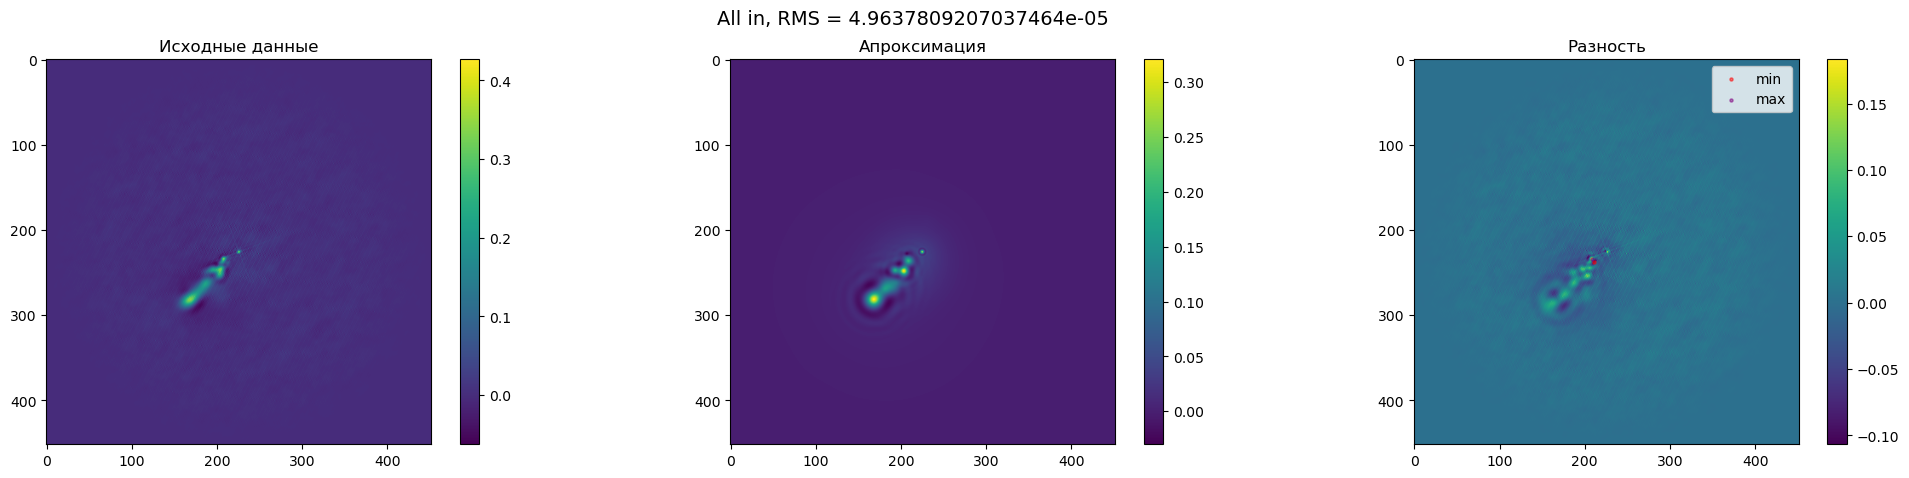

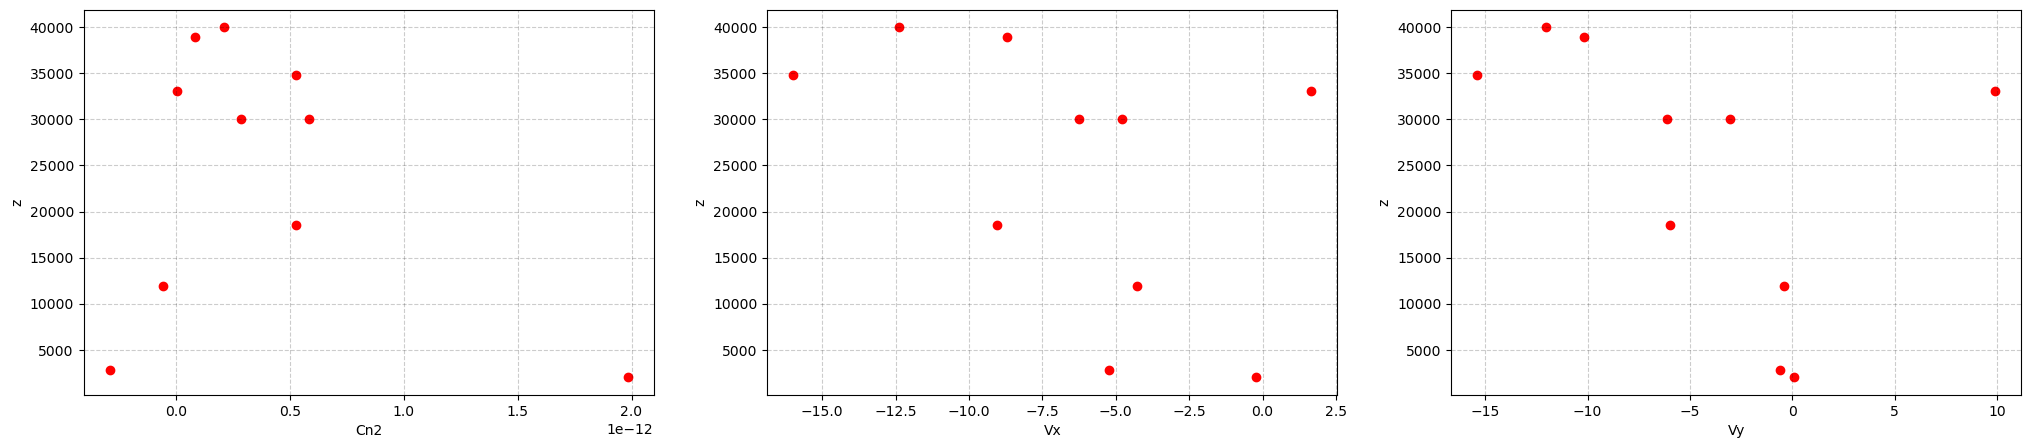

In [4]:
fit, popt, Cn2v = one_speckle_fit(params=myparams2)
popt = np.round(popt, 2)
z=[]
vx=[]
vy=[]
for i in range(len(popt)//3):
    z.append(popt[3*i+2])
    vx.append(popt[3*i])
    vy.append(popt[3*i+1]) 

profile = np.stack((z, vx, vy))


fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
cr = data.shape[0]//2 # центр изображения

fig.colorbar(ax.imshow(data), ax=ax)
ax.set_title('Исходные данные')
fig.colorbar(ax2.imshow(fit), ax=ax2)
ax2.set_title('Апроксимация')
fig.colorbar(ax3.imshow(data-fit), ax=ax3)
ax3.set_title('Разность')
ax3.scatter(np.unravel_index(np.argmin(data-fit), (data-fit).shape)[1], 
            np.unravel_index(np.argmin(data-fit), (data-fit).shape)[0], color='red', alpha=0.5, s=5, label='min')
ax3.scatter(np.unravel_index(np.argmax(data-fit), (data-fit).shape)[1],
            np.unravel_index(np.argmax(data-fit), (data-fit).shape)[0], color='purple', alpha=0.5, s=5, label='max')
ax3.legend()
fig.suptitle(f'All in, RMS = {np.mean((data - fit)**2)}', fontsize=14)

fig, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(25, 5))

ax4.scatter(Cn2v, profile[0], color='red')
ax5.scatter(profile[1], profile[0], color='red')
ax6.scatter(profile[2], profile[0], color='red')
ax4.set_xlabel('Cn2')
ax4.set_ylabel('z')
ax5.set_xlabel('Vx')
ax5.set_ylabel('z')
ax6.set_xlabel('Vy')
ax6.set_ylabel('z')
ax4.grid(color = 'black', linestyle='--', alpha = 0.2)
ax5.grid(color = 'black', linestyle='--', alpha = 0.2)
ax6.grid(color = 'black', linestyle='--', alpha = 0.2)

print('min value fit:', np.min(data-fit), 'coords:', np.unravel_index(np.argmin(data-fit), (data-fit).shape))
print('max value fit:', np.max(data-fit), 'coords:', np.unravel_index(np.argmax(data-fit), (data-fit).shape))
print('centr value:', (data-fit)[226, 226])

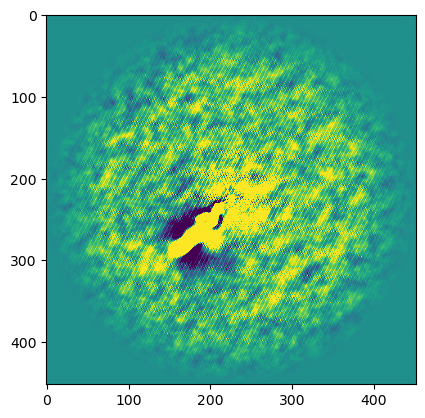

In [5]:
plt.imshow(data, vmin=-0.01, vmax=0.01)

In [6]:
# клин подходит не оч на большом кол-ве итерраций, т.к. он принимает остаточные маленькие пики за новые слои, в то время как
# они не принадлежат других слоям, а являются всего лишь остатками предыдуших

# маску не делать - Борис

# 1. попробовать передать в керв-фит сразу все начальные приближения
# 3. что если гамму вообще научиться сплющивать и поворачивать, чтобы подгонять ее под сам пик
# 4. что если к Оцу применять гамма-коррекцию, чтобы не так жестко обрезал